# Music Mood Classification - DA 623 Computing with Signals - Course Project

**Author:** Vidya Sagar G  
**Roll No:** 210123073    
**Institution:** IIT Guwahati  
**Project Type:** Course Project 

---

##  Project Scope

This project aims to explore **multimodal mood classification** in music by analyzing both **lyrics** (text) and **audio features**. Mood detection in songs is a key task in affective computing and music recommendation systems, and it requires modeling both **semantic content** and **acoustic signals**.

While the broader research and design are centered around **audio–text fusion**, the current implementation focuses solely on the **text modality (lyrics-based classification)**. The project is exploratory in nature and efforts to include audio features (via YouTube audio extraction) were unsuccessful due to copyright restrictions and inconsistent access to full tracks.

---

##  Motivation & Background

Music has always been a deeply expressive medium, capable of conveying emotions, moods, and narratives through both sound and language. As someone interested in music and having recently explored Natural Language Processing (NLP), I was excited to apply computational techniques to the intersection of music and machine learning.

This project explores the broader problem of **multimodal mood classification in music**, where both **lyrics (text)** and **audio signals** contribute to understanding the emotional tone of a song. While lyrics offer semantic and narrative context, the audio modality carries vital cues about rhythm, instrumentation, pitch, and vocal delivery — all of which influence how a listener perceives mood. The task has significant applications in **music recommendation systems**, and **emotion-aware interfaces** for instance.

---


##  Historical Context

Music mood classification has evolved across three main phases:

### 1. Audio-based methods

Early studies relied only on audio features:

- **Tempo**, **timbre**, **rhythm**, and **spectral features** (e.g., MFCCs)
- Classical models like SVMs, KNNs on extracted signal features
- Focused on genre or emotion classification using raw audio

### 2. Lyrics-based methods

With advances in NLP, researchers began analyzing song lyrics:

- Used Bag-of-Words (BoW), TF-IDF, Word2Vec, and GloVe
- Treated mood prediction as a text classification problem
- Captured themes and emotions conveyed in words

### 3. Multimodal learning

Recent work combines both audio and text:

- Fusion of acoustic and semantic features improves accuracy
- Deep models extract joint representations from both modalities
- Key examples:
  - Laurier et al. (2008): Combined timbre + lyric features
  - Delbouys et al. (2018): Used CNNs on audio + embeddings from lyrics

This shift shows that neither audio nor text alone is sufficient—multimodal models are now the state of the art.

---

## What My Project Is

This project focuses on **music mood classification** using only **song lyrics**.

While the original goal was to build a **multimodal model** (lyrics + audio) and it is still a work in progress, audio integration was deferred due to copyright and data access issues. The current implementation is **text-only**.

### Pipeline Overview

- **Preprocessing**:
  - Lowercasing, tokenization, stopword removal, lemmatization

- **Feature Extraction**:
  - TF-IDF vectors
  - GloVe (100D average word embeddings)
  - MiniLM sentence embeddings (from BERT)

- **Models Trained**:
  - Logistic Regression
  - Random Forest
  - Support Vector Machine (SVM)
  - Naive Bayes (TF-IDF only)

- **Evaluation**:
  - Accuracy
  - F1-score
  - Confusion matrices

## Importing Necessary Libraries

In [1]:
import os
import re
import subprocess
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

## Dataset Description

I use the **NJU Music Mood Dataset** ([link](https://cs.nju.edu.cn/sufeng/data/musicmood.htm)), which contains a total of **777 music clips** labeled across **four mood categories**:

- Angry  
- Happy  
- Relaxed  
- Sad  

Out of the 777 samples:
- **400 clips** are used for training  
- **377 clips** are used for testing  

The dataset provides:
- Plain text `.txt` files for each music clip containing **song lyrics**
- Each sentence is timestamped with the offset `[hh:mm:ss]` from the start of the track

> Due to **copyright constraints**, only lyrics and tags are available; full-length audio clips are not accessible.

### Sample Distribution

| Mood Category | Training Samples | Testing Samples |
|---------------|------------------|-----------------|
| Angry         | 100              | 71              |
| Happy         | 100              | 106             |
| Relaxed       | 100              | 101             |
| Sad           | 100              | 99              |

In [2]:
# Root directory where Angry/, Happy/, etc. folders are located
DATA_DIR = "C:\\All data\\IITG\\Acads\\Eighth semester\\DA623 Computing with Signals\\Course Project\\Data"  # Change this to your actual path

# List of mood categories (folder names)
mood_dirs = ["Angry", "Happy", "Relaxed", "Sad"]

# Split of train and test data
splits = ["train", "test"]

In [3]:
all_data = []

for mood in mood_dirs:
    for split in splits:
        folder = os.path.join(DATA_DIR, mood, split)
        info_path = os.path.join(folder, "info.txt")

        if not os.path.exists(folder):
            print(f"Folder not found: {folder}")
            continue

        # --- Parse info.txt ---
        song_info = {}
        if os.path.exists(info_path):
            with open(info_path, "r", encoding="utf-8", errors="replace") as f:
                for line in f:
                    parts = line.strip().split(":")
                    if len(parts) < 3:
                        print(f"Skipping malformed line: {line.strip()}")
                        continue
                    index = parts[0].strip()
                    artist = parts[-2].strip()
                    title = ":".join(parts[1:-2]).strip()
                    song_info[index] = {
                        "title": title,
                        "artist": artist
                    }

        # --- Process lyric files ---
        for filename in os.listdir(folder):
            if filename.endswith(".txt") and filename != "info.txt":
                try:
                    # Extract index: happy_1.txt → 1
                    name_parts = filename.replace(".txt", "").split("_")
                    if len(name_parts) != 2:
                        print(f"Unexpected filename format: {filename}")
                        continue
                    index = name_parts[1]

                    file_path = os.path.join(folder, filename)
                    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
                        lines = f.readlines()
                        lyrics = []
                        for line in lines:
                            clean_line = re.sub(r'\[\d{2}:\d{2}(?:\.\d{2})?\]', '', line).strip()
                            if clean_line:
                                lyrics.append(clean_line)
                        lyrics = ".".join(lyrics)

                    title = song_info.get(index, {}).get("title", "Unknown")
                    artist = song_info.get(index, {}).get("artist", "Unknown")

                    all_data.append({
                        "mood": mood,
                        "split": split,
                        "index": index,
                        "title": title,
                        "artist": artist,
                        "lyrics": lyrics
                    })

                except Exception as e:
                    print(f"Error reading {filename}: {e}")

In [4]:
# Final DataFrame
df = pd.DataFrame(all_data)
df.to_csv("lyrics_dataset.csv", index=False)
print(f"Saved lyrics_dataset.csv with {len(df)} rows.")

Saved lyrics_dataset.csv with 777 rows.


In [5]:
df.head()

,mood,split,index,title,artist,lyrics
0,Angry,train,1,All Messed Up,Sum 41,Another day wasted out of time.I can't get out...
1,Angry,train,10,Before You Die,Bad Religion,Decaying’ ever faster..Under wear all the immi...
2,Angry,train,100,Pride:Manchester Orchestra,Manchester Orchestra,Finally I felt the calming breeze.Stepping out...
3,Angry,train,11,Blood Red,Slayer,Peaceful confrontation meet war machine.Seizin...
4,Angry,train,12,You Oughta Know,Alanis Morissette,"I want you to know, that I'm happy for you.I w..."


Splitting the data according to the standard split

In [6]:
df = pd.read_csv("lyrics_dataset.csv")
train_df = df[df['split'] == 'train'].copy()
test_df = df[df['split'] == 'test'].copy()
train_df.head()

,mood,split,index,title,artist,lyrics
0,Angry,train,1,All Messed Up,Sum 41,Another day wasted out of time.I can't get out...
1,Angry,train,10,Before You Die,Bad Religion,Decaying’ ever faster..Under wear all the immi...
2,Angry,train,100,Pride:Manchester Orchestra,Manchester Orchestra,Finally I felt the calming breeze.Stepping out...
3,Angry,train,11,Blood Red,Slayer,Peaceful confrontation meet war machine.Seizin...
4,Angry,train,12,You Oughta Know,Alanis Morissette,"I want you to know, that I'm happy for you.I w..."


In [7]:
test_df.head()

,mood,split,index,title,artist,lyrics
100,Angry,test,1,'Till I Collapse,Eminem,"Sometimes you just feel tired, feel weak.When ..."
101,Angry,test,10,Ridin',"Chamillionaire,sway",They see me rolling.They hating.Patrolling the...
102,Angry,test,11,Rootless Tree,Damien Rice,What I want from you is empty your head..But t...
103,Angry,test,12,Rush,Talib Kweli,"Rush - Talib Kweli.Feel the rush.Yeah, I do th..."
104,Angry,test,13,Screaming For Vengeance,Judas Priest,Screaming For Vengeance-Judas Priest.Hey liste...


---

I use the `nltk` library to preprocess the raw song lyrics before feature extraction. This involves downloading necessary resources such as the Punkt tokenizer, WordNet lemmatizer, POS tagger, and English stopwords. Each lyric is first tokenized into words, and then POS-tagged using `nltk.pos_tag`. To enhance lemmatization accuracy, I map POS tags to the format expected by WordNet (e.g., adjectives, verbs, nouns).

The text is then lemmatized using `WordNetLemmatizer`, and common stopwords and punctuation are removed. All tokens are converted to lowercase to ensure uniformity. This process reduces noise and standardizes the text data for input into TF-IDF, GloVe, or BERT-based embeddings.

In [8]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Vidyasagar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vidyasagar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vidyasagar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vidyasagar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vidyasagar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [10]:
tag_map = defaultdict(lambda: wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV

In [11]:
def preprocess(text):
    words = word_tokenize(text.lower())
    final_words = []
    for word, tag in pos_tag(words):
        if word.isalpha() and word not in stop_words:
            final_words.append(lemmatizer.lemmatize(word, tag_map[tag[0]]))
    return " ".join(final_words)

In [12]:
train_df['text_final'] = train_df['lyrics'].apply(preprocess)
test_df['text_final'] = test_df['lyrics'].apply(preprocess)

To convert the mood labels into a machine-readable format, I use `LabelEncoder` from `sklearn`. This maps each string label (e.g., "happy", "sad") to a unique integer. For example, `{'angry': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}`. This encoded format is necessary for training classification models.

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df['mood'])
y_test = le.transform(test_df['mood'])

## Feature Extraction: TF-IDF Vectorizer

I first use the `TfidfVectorizer` from `sklearn` to convert the preprocessed lyrics into numerical features. TF-IDF (Term Frequency–Inverse Document Frequency) measures how important a word is to a document relative to the entire corpus. Common words across songs are downweighted, while rare but informative words are given higher weight.

In our setup, each song lyric is transformed into a sparse vector of TF-IDF scores, with a maximum vocabulary size of 5000. This representation captures the relevance of words while avoiding raw frequency bias. These vectors are then passed to classical machine learning models for mood classification.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['text_final'])
X_test = vectorizer.transform(test_df['text_final'])

## Models Trained

We trained four classical machine learning classifiers using the extracted features:

- **Logistic Regression**: A strong baseline for text classification.
- **Random Forest**: An ensemble model that handles non-linear patterns and is robust to overfitting.
- **Support Vector Machine (SVM)**: Effective in high-dimensional spaces like TF-IDF and embeddings.
- **Naive Bayes**: Applied only with TF-IDF, since it assumes feature independence.

Each model was trained separately on features from TF-IDF, GloVe, and BERT (except Naive Bayes).

## Evaluation

Model performance was evaluated using:

- **Accuracy**: Overall correctness of predictions.
- **F1-Score**: Balances precision and recall across mood classes.
- **Confusion Matrix**: Visualizes per-class performance and misclassification patterns.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay 

In [16]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": LinearSVC()
}

In [17]:
def plot_confusion_matrix(y_true, y_pred, label_encoder, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [18]:
def benchmark_models(X_train, y_train, X_test, y_test, label_encoder, models):
    results = {}
    for name, model in models.items():
        print(f"\n=== {name} ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        results[name] = acc
        plot_confusion_matrix(y_test, y_pred, le, title="Confusion Matrix - TF-IDF Vectorizer")
    return results


=== Logistic Regression ===
Accuracy: 0.4244
              precision    recall  f1-score   support

       Angry       0.52      0.63      0.57        71
       Happy       0.46      0.59      0.52       106
     Relaxed       0.30      0.24      0.27       101
         Sad       0.38      0.28      0.32        99

    accuracy                           0.42       377
   macro avg       0.41      0.44      0.42       377
weighted avg       0.41      0.42      0.41       377



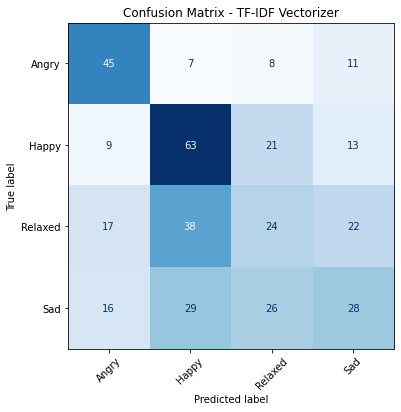


=== Naive Bayes ===
Accuracy: 0.4164
              precision    recall  f1-score   support

       Angry       0.77      0.52      0.62        71
       Happy       0.48      0.42      0.44       106
     Relaxed       0.29      0.26      0.27       101
         Sad       0.34      0.51      0.41        99

    accuracy                           0.42       377
   macro avg       0.47      0.42      0.44       377
weighted avg       0.45      0.42      0.42       377



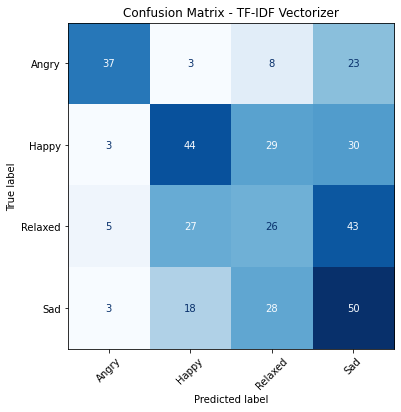


=== Random Forest ===
Accuracy: 0.4456
              precision    recall  f1-score   support

       Angry       0.60      0.72      0.65        71
       Happy       0.45      0.53      0.49       106
     Relaxed       0.37      0.30      0.33       101
         Sad       0.36      0.31      0.34        99

    accuracy                           0.45       377
   macro avg       0.44      0.46      0.45       377
weighted avg       0.43      0.45      0.44       377



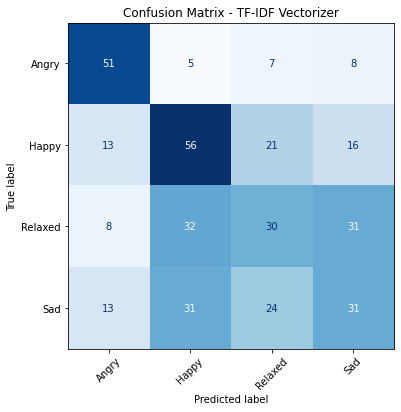


=== SVM ===
Accuracy: 0.4138
              precision    recall  f1-score   support

       Angry       0.58      0.65      0.61        71
       Happy       0.44      0.54      0.49       106
     Relaxed       0.25      0.20      0.22       101
         Sad       0.37      0.33      0.35        99

    accuracy                           0.41       377
   macro avg       0.41      0.43      0.42       377
weighted avg       0.40      0.41      0.40       377



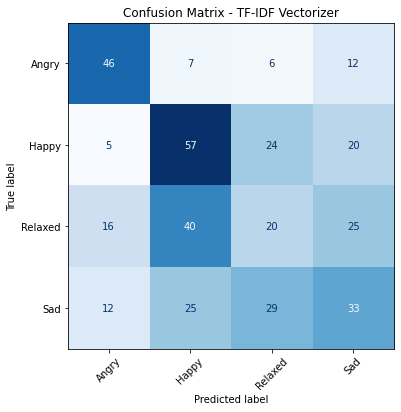

In [19]:
results = benchmark_models(X_train, y_train, X_test, y_test, le, models)

## Feature Extraction: GloVe Word Embeddings

I use pretrained **GloVe word embeddings** (100-dimensional, `glove.6B.100d.txt`) to capture semantic meaning from lyrics. Each word is mapped to a dense vector based on its co-occurrence statistics in a large corpus.

To obtain a fixed-size representation for each song, I average the GloVe vectors of all valid words in the preprocessed lyrics. This yields a single 100D vector per sample. Unlike TF-IDF, GloVe captures semantic similarity between words, making it more robust to vocabulary variation.

In [20]:
import gensim.downloader as api
import numpy as np

In [21]:
# Load pretrained embeddings
glove = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors

def average_embedding(text):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X_train_embed = np.vstack(train_df["text_final"].apply(average_embedding))
X_test_embed = np.vstack(test_df["text_final"].apply(average_embedding))

In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": LinearSVC(),
    # Note: Naive Bayes doesn't work well with negative/real-valued features
}

In [23]:
def benchmark_models(X_train, y_train, X_test, y_test, label_encoder, models):
    results = {}
    for name, model in models.items():
        print(f"\n=== {name} ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        results[name] = acc
        plot_confusion_matrix(y_test, y_pred, le, title="Confusion Matrix - GloVe word embeddings")
    return results


=== Logistic Regression ===
Accuracy: 0.4244
              precision    recall  f1-score   support

       Angry       0.52      0.63      0.57        71
       Happy       0.46      0.59      0.52       106
     Relaxed       0.30      0.24      0.27       101
         Sad       0.38      0.28      0.32        99

    accuracy                           0.42       377
   macro avg       0.41      0.44      0.42       377
weighted avg       0.41      0.42      0.41       377



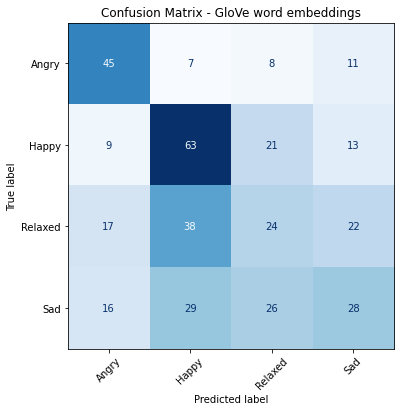


=== Random Forest ===
Accuracy: 0.4191
              precision    recall  f1-score   support

       Angry       0.60      0.62      0.61        71
       Happy       0.40      0.54      0.46       106
     Relaxed       0.33      0.28      0.30       101
         Sad       0.37      0.29      0.33        99

    accuracy                           0.42       377
   macro avg       0.43      0.43      0.43       377
weighted avg       0.41      0.42      0.41       377



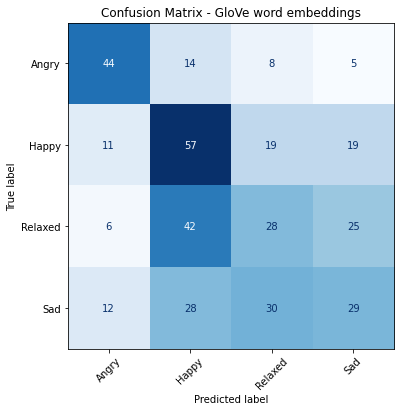


=== SVM ===
Accuracy: 0.4138
              precision    recall  f1-score   support

       Angry       0.58      0.65      0.61        71
       Happy       0.44      0.54      0.49       106
     Relaxed       0.25      0.20      0.22       101
         Sad       0.37      0.33      0.35        99

    accuracy                           0.41       377
   macro avg       0.41      0.43      0.42       377
weighted avg       0.40      0.41      0.40       377



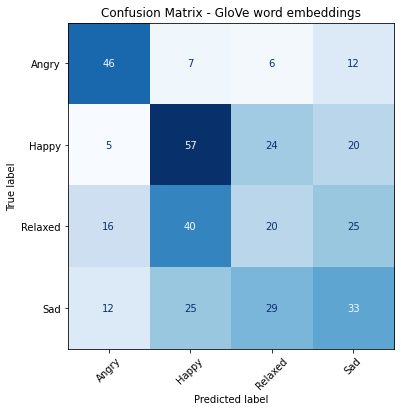

In [24]:
results = benchmark_models(X_train, y_train, X_test, y_test, le, models)

## Feature Extraction: BERT (MiniLM Embeddings)

I also experiment with contextual embeddings using **MiniLM**, a lightweight variant of BERT from the `sentence-transformers` library. Each song lyric is treated as a single input sentence, and the model outputs a dense 384-dimensional sentence embedding.

MiniLM captures not only word meanings but also their contextual relationships. This allows it to encode subtle emotional cues present in sentence structure or phrasing. These embeddings are fed directly into downstream classifiers.

In [25]:
#!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

In [26]:
# Load BERT model and encode lyrics
print("Loading BERT model and generating embeddings...")
bert = SentenceTransformer('all-MiniLM-L6-v2')  # Fast, ~384-dim

X_train_bert = bert.encode(train_df['lyrics'].tolist(), show_progress_bar=True)
X_test_bert = bert.encode(test_df['lyrics'].tolist(), show_progress_bar=True)

Loading BERT model and generating embeddings...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [27]:
# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": LinearSVC()
}

In [28]:
def benchmark_models(X_train, y_train, X_test, y_test, label_encoder, models):
    results = {}
    for name, model in models.items():
        print(f"\n=== {name} ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        results[name] = acc
        plot_confusion_matrix(y_test, y_pred, le, title="Confusion Matrix - BERT Transformer")
    return results


=== Logistic Regression ===
Accuracy: 0.4244
              precision    recall  f1-score   support

       Angry       0.52      0.63      0.57        71
       Happy       0.46      0.59      0.52       106
     Relaxed       0.30      0.24      0.27       101
         Sad       0.38      0.28      0.32        99

    accuracy                           0.42       377
   macro avg       0.41      0.44      0.42       377
weighted avg       0.41      0.42      0.41       377



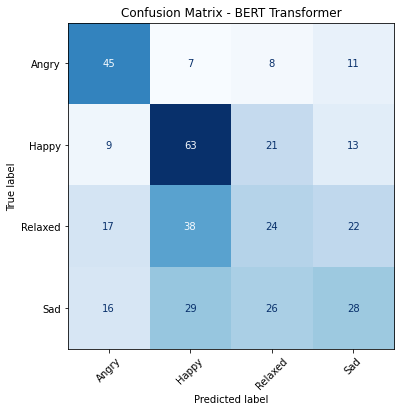


=== Random Forest ===
Accuracy: 0.4191
              precision    recall  f1-score   support

       Angry       0.64      0.62      0.63        71
       Happy       0.39      0.52      0.45       106
     Relaxed       0.35      0.29      0.32       101
         Sad       0.35      0.30      0.33        99

    accuracy                           0.42       377
   macro avg       0.43      0.43      0.43       377
weighted avg       0.42      0.42      0.41       377



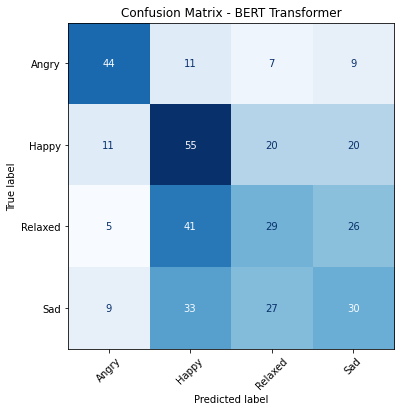


=== SVM ===
Accuracy: 0.4138
              precision    recall  f1-score   support

       Angry       0.58      0.65      0.61        71
       Happy       0.44      0.54      0.49       106
     Relaxed       0.25      0.20      0.22       101
         Sad       0.37      0.33      0.35        99

    accuracy                           0.41       377
   macro avg       0.41      0.43      0.42       377
weighted avg       0.40      0.41      0.40       377



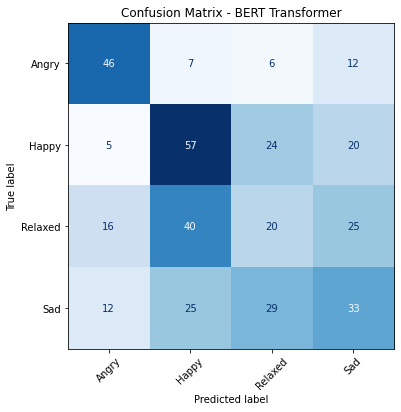

In [29]:
results = benchmark_models(X_train, y_train, X_test, y_test, le, models)

## Observations and Limitations

Despite experimenting with multiple features and models, classification accuracy plateaued around **40%**, with minimal variation across TF-IDF, GloVe, and BERT embeddings. This indicates that lyrics alone do not carry enough discriminative signal to capture musical mood reliably.

One key limitation is the **size and nature of the dataset**—with only **777 samples** across four mood classes, the model lacks sufficient training data to learn complex patterns. Additionally, mood is often conveyed not just through words, but through **vocal tone, tempo, instrumentation, and rhythm**—none of which are captured by text alone.

These observations strongly support the need for **multimodal learning**, where lyrics are combined with **audio features** such as MFCCs, chroma, tempo, and energy-based metrics. Future work will explore such fusion-based architectures to improve mood classification performance.

---

## References

- Laurier, C., Lartillot, O., Eerola, T., & Herrera, P. (2008). *Multimodal mood classification using audio and lyrics*. In Proceedings of the International Society for Music Information Retrieval (ISMIR).

- Delbouys, R., Royo-Letelier, J., Hennequin, R., & Pachet, F. (2018). *Music mood detection based on audio and lyrics with deep neural net*. arXiv preprint arXiv:1809.07276.

- Pennington, J., Socher, R., & Manning, C. D. (2014). *GloVe: Global Vectors for Word Representation*. In EMNLP.

- Reimers, N., & Gurevych, I. (2019). *Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks*. In EMNLP. [https://www.sbert.net](https://www.sbert.net)

- NJU Music Mood Dataset: [https://cs.nju.edu.cn/sufeng/data/musicmood.htm](https://cs.nju.edu.cn/sufeng/data/musicmood.htm)

- scikit-learn Documentation: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)

- NLTK Documentation: [https://www.nltk.org/](https://www.nltk.org/)
